In [1]:
# import os
import time

import numpy as np
import matplotlib.pyplot as plt

import jax
from jax import numpy as jnp
from jax import random

import optax

from src.QDDPM_jax import QDDPM, HaarSampleGeneration
from src.distance_jax import naturalDistance, sinkhornDistance

# rc('text', usetex=True)
# rc('axes', linewidth=3)

2024-01-12 08:20:08.619089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module
/home/francishsu/miniconda3/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(2, 3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [2]:
# check device
print(jax.lib.xla_bridge.get_backend().platform)

gpu


In [12]:
def Training_t(model, t, inputs_T, params_tot, init=None, epochs=1200, dis_measure='sink', learning_rate=1e-3, reg=0.001, threshold=1e-4):
    '''
    training for the backward PQC at step t using whole dataset
    Args:
    model: QDDPM model
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t
    init: initial parameters of the circuit
    epochs: number of iterations
    dis_measure: the distance measure to compare two distributions of quantum states
    dis_params: potential hyper-parameters for distance measure
    '''
    Ndata = inputs_T.shape[0]

    input_tplus1 = model.prepareInput_t(
        inputs_T, params_tot, t, Ndata)  # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    key = random.PRNGKey(np.random.randint(low=0, high=10000))

    if init is None:
        param_shape = 2 * model.n_tot * model.L
        params_t = random.normal(key, shape=(param_shape, ))
    else:
        params_t = init


    # set optimizer and learning rate decay
    optimizer = optax.adam(learning_rate=learning_rate)
    opt_state = optimizer.init(params_t)

    if dis_measure == 'nat':
        dist_func = naturalDistance
    elif dis_measure == 'sink':
        def dist_func(x, y): return sinkhornDistance(
            x, y, reg=reg, threshold=threshold)

    def loss_func(params_t, input_tplus1, true_data):
        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = dist_func(output_t, true_data)

        return loss

    loss_func_vg = jax.jit(jax.value_and_grad(loss_func))

    def update(params_t, input_tplus1, true_data, opt_state):
        loss_value, grads = loss_func_vg(params_t, input_tplus1, true_data)
        updates, new_opt_state = optimizer.update(grads, opt_state, params_t)
        new_params_t = optax.apply_updates(params_t, updates)

        return new_params_t, new_opt_state, loss_value

    # t0 = time.time()
    for _ in range(epochs):
        np.random.seed()
        indices = np.random.choice(
            states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        params_t, opt_state, loss_value = update(
            params_t, input_tplus1, true_data, opt_state)

        # if step % 600 == 0:
        #     print("Step {}, loss: {:.7f}, time elapsed: {:.4f} seconds".format(
        #         step, loss_value, time.time() - t0))

        loss_hist.append(loss_value)  # record the current loss

    return params_t, loss_hist

In [14]:
n, na = 1, 1
T = 20
L = 4

Ndata = 100
epochs = 2500

inputs_T = HaarSampleGeneration(Ndata, 2 ** n, seed=42)
# states_diff = jnp.load('data/tfim/tfimDiff_n4T30_N10000.npy')
states_diff = jnp.load('data/cluster/cluster0Diff_n1T20_N100.npy')

In [15]:
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

In [16]:
loss_list = []
params_tot = jnp.zeros((T, 2 * (n + na) * L))

param = None
t0 = time.time()
for t in range(T - 1, -1, -1):
    params, loss = Training_t(model, t, inputs_T, params_tot, param, epochs, 'sink', reg=0.001, threshold=1e-5)
    params_tot = params_tot.at[t].set(params)
    loss_list.append(loss)
    # clear_output(wait=True)
    print("==========================================================")
    print("Iteration {} done, time elapsed: {:.4f} seconds".format(t, time.time() - t0))

Iteration 19 done, time elapsed: 35.5744 seconds
Iteration 18 done, time elapsed: 69.5228 seconds
Iteration 17 done, time elapsed: 102.9260 seconds
Iteration 16 done, time elapsed: 136.3285 seconds
Iteration 15 done, time elapsed: 169.5719 seconds
Iteration 14 done, time elapsed: 203.2555 seconds
Iteration 13 done, time elapsed: 237.5395 seconds
Iteration 12 done, time elapsed: 270.9365 seconds
Iteration 11 done, time elapsed: 303.5568 seconds
Iteration 10 done, time elapsed: 336.8079 seconds
Iteration 9 done, time elapsed: 371.3032 seconds
Iteration 8 done, time elapsed: 403.8002 seconds
Iteration 7 done, time elapsed: 437.0992 seconds
Iteration 6 done, time elapsed: 470.7917 seconds
Iteration 5 done, time elapsed: 504.8352 seconds
Iteration 4 done, time elapsed: 535.8318 seconds
Iteration 3 done, time elapsed: 568.7173 seconds
Iteration 2 done, time elapsed: 593.1541 seconds
Iteration 1 done, time elapsed: 605.2224 seconds
Iteration 0 done, time elapsed: 618.6231 seconds


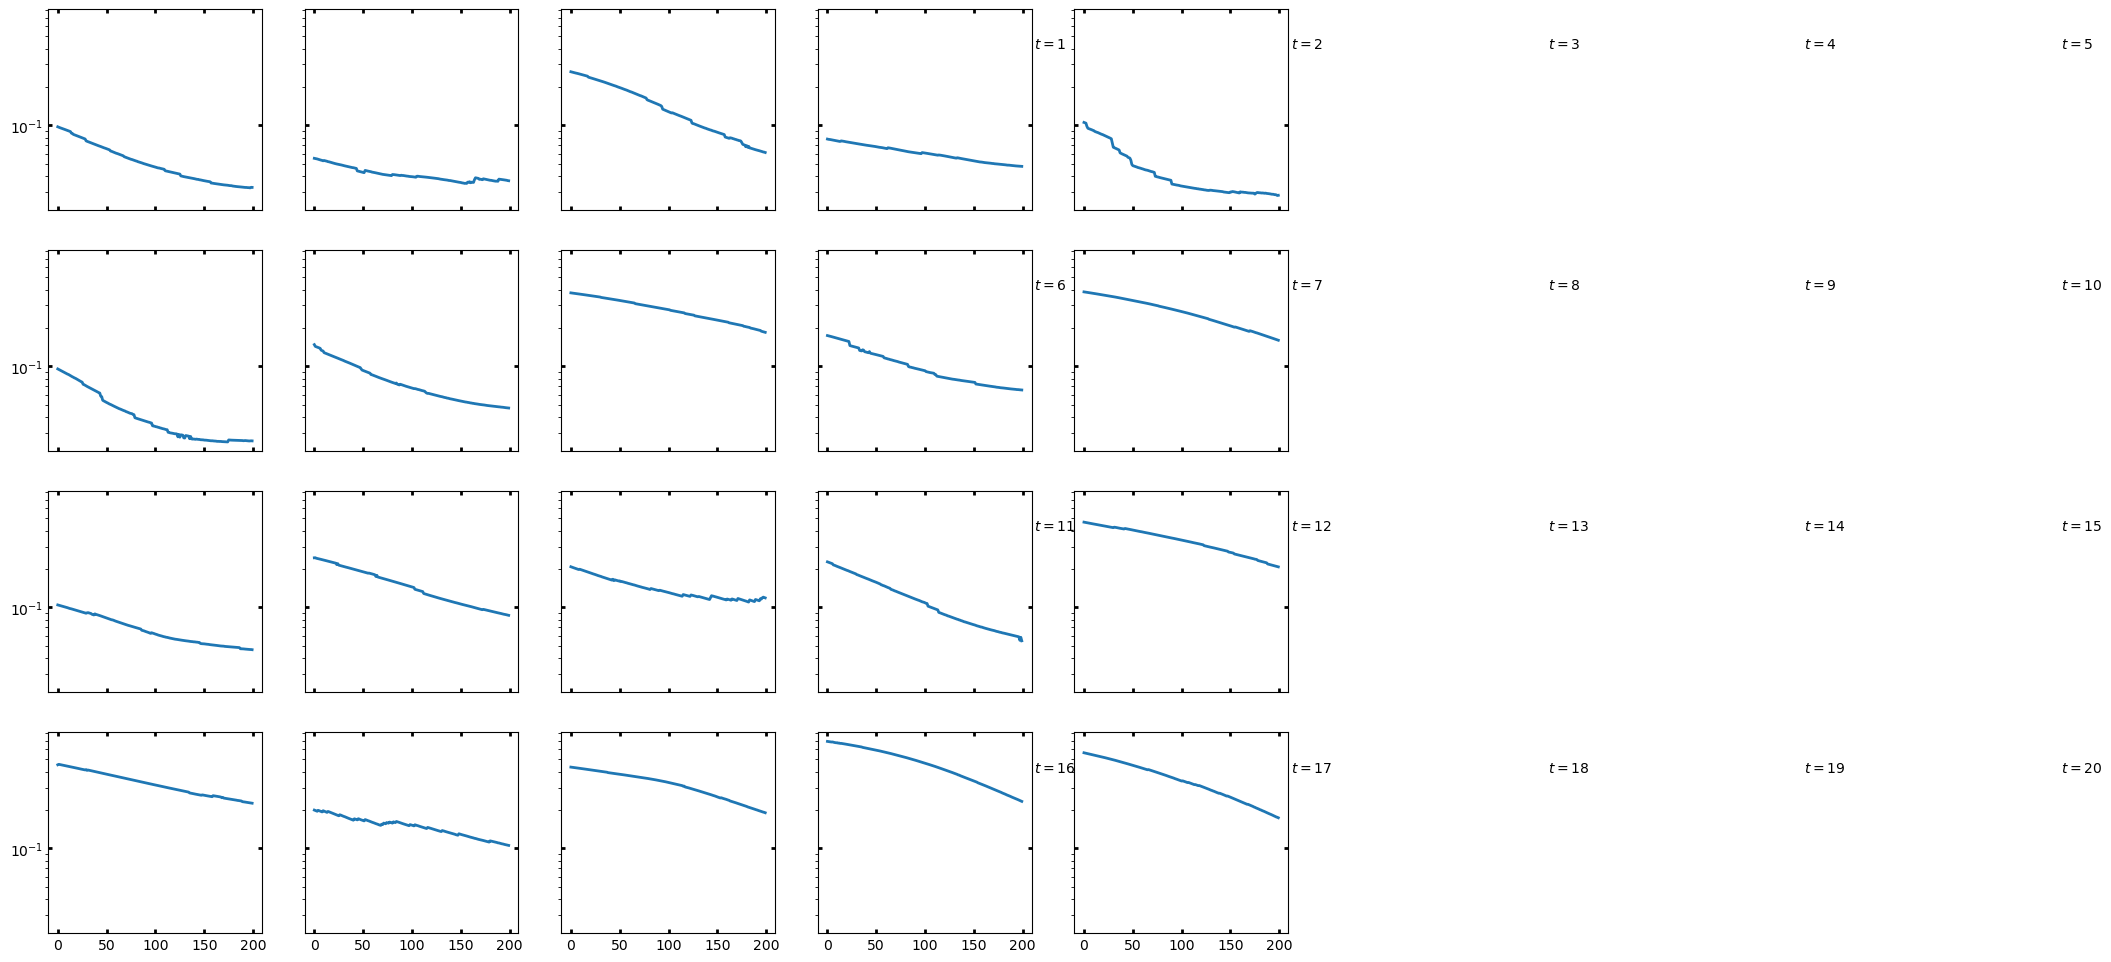

In [18]:
fig, axs = plt.subplots(4, 5, figsize=(16, 12), sharex=True, sharey=True)
for i in range(T):
    axs[i // 5, i % 5].plot(loss_list[i], lw=2)
    axs[i // 5, i % 5].tick_params(direction='in', length=3, width=2, top='on', right='on', labelsize=10)
    axs[i // 5, i % 5].text(x=1000, y=0.4, s=r'$t=%d$'%(i+1), fontsize=10)
    axs[i // 5, i % 5].set_yscale('log')

In [19]:
jnp.save('output/cluster0Diff_n1T20_N100_param_sink.npy', params_tot)

In [20]:
loss_array = jnp.array(loss_list)
jnp.save('output/cluster0Diff_n1T20_N100_loss.npy', loss_array)